<a href="https://colab.research.google.com/github/4juneko/Aiffel_work/blob/master/20__translator_seq2seq_wordLevel_06122023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rubric
|평가문항|	상세기준|내 평가|
|--|--|--|
|1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 잘 이루어졌다.	|구두점, 대소문자, 띄어쓰기 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.|o|
|2. seq2seq 기반의 번역기 모델이 정상적으로 구동된다.|	seq2seq 모델 훈련결과를 그래프로 출력해보고, validation loss그래프가 우하향하는 경향성을 보이며 학습이 진행됨이 확인되었다.|o|
|3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.	|테스트용 디코더 모델이 정상적으로 만들어졌으며, input(영어)와 output(프랑스어) 모두 한글로 번역해서 결과를 출력해보았고, 둘의 내용이 유사함을 확인하였다.|x|

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [ ]:
import tensorflow

print(tensorflow.__version__)

2.6.0


In [ ]:
import os
file_path = os.getenv('HOME')+'/aiffel/translator_seq2seq/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수 :',len(lines))
lines.sample(5) #샘플 5개 출력

전체 샘플의 수 : 217975


,eng,fra,cc
159816,You don't have to do what Tom says.,Vous n'avez pas à suivre Tom.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
38353,Has Tom calmed down?,Tom s'est-il calmé?,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
38122,Don't make me blush.,Ne me faites pas rougir.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
217663,Yesterday the unveiling of the founder's statu...,Hier a eu lieu l'inauguration de la statue du ...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
102643,You're the one responsible.,C'est toi qui es responsable.,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


In [ ]:
lines_ef = lines[['eng', 'fra']][:53000].copy().reset_index(drop=True) # 3.3만개 샘플 사용
lines_ef.head(5)

# 앞에 있는 33000개를 추출하여 학습하였더니 다소 짧은 문장으로 성능이 좋지 않은 거 같아 중간 쯤의 문장을 선택해봄.

,eng,fra
0,Go.,Va !
1,Go.,Marche.
2,Go.,En route !
3,Go.,Bouge !
4,Hi.,Salut !


In [ ]:
type(lines_ef)

pandas.core.frame.DataFrame

In [ ]:
lines_ef[10000:10005]

,eng,fra
10000,What are you accusing me of?,De quoi est-ce que tu m'accuses ?
10001,What are you all doing here?,Qu'êtes-vous tous en train de faire ici ?
10002,What are you all doing here?,Qu'êtes-vous toutes en train de faire ici ?
10003,What are you doing tomorrow?,Tu fais quoi demain ?
10004,What are you hiding from me?,Qu'est-ce que tu me caches ?


# 1 Refine, normalize, preprocess

In [ ]:
import os, re

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자로, 공백 없애기
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence)
    sentence = sentence.strip() # 5. 양쪽 공백 지우기. 1번에서도 공백 없애기 했는데 두번째이네
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러개 공백은 공백 하나로

    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence(lines_ef.eng[2126]))

i ll do it .


In [ ]:
from nltk.tokenize import TreebankWordTokenizer, WordPunctTokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

tokenizer = TreebankWordTokenizer() # 하이픈 단어 유지. doesn't는 does와 n't로
# tokenizer = WordPunctTokenizer() # don't를 don과 t로 jone's를 jone와 s로
# tokenizer = text_to_word_sequence # 컴마 느낌표 등 제거. don't, jone's는 보존  성능이 살짝 떨어졌음.

# https://wikidocs.net/21698
# 토크나이저에 따라 모델 성능이 크게 차이나는 거 같지 않음.

In [ ]:
len(lines_ef)

53000

In [ ]:
for i in range(len(lines_ef)):
    lines_ef.eng[i] = preprocess_sentence(lines_ef.eng[i])
    lines_ef.fra[i] = preprocess_sentence(lines_ef.fra[i]) # 특수문자 지우고 띄어쓰기
    lines_ef.eng[i] = tokenizer.tokenize(lines_ef.eng[i])
    lines_ef.fra[i] = tokenizer.tokenize(lines_ef.fra[i]) # 띄어쓰기한 거 나눠 리스트로 만들기

lines_ef.eng[0]

['go', '.']

In [ ]:
lines_ef[10000:10005]

# 2 Add Start & End Token
https://wikidocs.net/2850
- 디코더의 입력과 예측에는 시작 토큰 <sos>와 종료 토큰 <eos>가 필요
- 시작과 종료를 한꺼번에 넣고 숫자로 바꾼 뒤에 하나씩 빼줌

In [ ]:
lines_ef['fra'] = lines_ef['fra'].apply(lambda x: ["<sos>"] + x + ["<eos>"])

# append(['<sos>'])

In [ ]:
lines_ef[:5]

,eng,fra
0,"[go, .]","[<sos>, va, !, <eos>]"
1,"[go, .]","[<sos>, marche, ., <eos>]"
2,"[go, .]","[<sos>, en, route, !, <eos>]"
3,"[go, .]","[<sos>, bouge, !, <eos>]"
4,"[hi, .]","[<sos>, salut, !, <eos>]"


# 3 Word to Integer
https://wikidocs.net/31766

In [ ]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(lines_ef.eng)

# fit_on_texts는 입력한 텍스트로부터 단어 빈도수가 높은 순으로 낮은 정수 인덱스를 부여

In [ ]:
print(eng_tokenizer.word_index)

{'.': 1, 'i': 2, 'you': 3, '?': 4, 'tom': 5, 'it': 6, 'is': 7, 'a': 8, 's': 9, 't': 10, 're': 11, 'we': 12, 'the': 13, 'that': 14, 'm': 15, 'to': 16, 'he': 17, 'this': 18, 'me': 19, 'are': 20, 'do': 21, 'was': 22, 'can': 23, 'they': 24, 'have': 25, 'your': 26, 'my': 27, 'don': 28, 'not': 29, 'what': 30, 'did': 31, '!': 32, 'go': 33, 'll': 34, 'be': 35, 'all': 36, 'like': 37, 'she': 38, 'in': 39, 'no': 40, 'here': 41, 'very': 42, 'how': 43, 'let': 44, 'on': 45, 'of': 46, 'get': 47, 'want': 48, 'know': 49, 'need': 50, 'up': 51, ',': 52, 'one': 53, 'who': 54, 'for': 55, 've': 56, 'there': 57, 'out': 58, 'him': 59, 'good': 60, 'so': 61, 'now': 62, 'were': 63, 'got': 64, 'please': 65, 'at': 66, 'come': 67, 'just': 68, 'why': 69, 'help': 70, 'love': 71, 'too': 72, 'look': 73, 'where': 74, 'has': 75, 'us': 76, 'will': 77, 'take': 78, 'see': 79, 'stop': 80, 'an': 81, 'had': 82, 'with': 83, 'didn': 84, 'his': 85, 'must': 86, 'back': 87, 'home': 88, 'won': 89, 'give': 90, 'am': 91, 'work': 92, '

In [ ]:
eng_text = eng_tokenizer.texts_to_sequences(lines_ef.eng)
eng_text[:5]

[[33, 1], [33, 1], [33, 1], [33, 1], [961, 1]]

In [ ]:
fra_tokenizer = Tokenizer()
fra_tokenizer.fit_on_texts(lines_ef.fra)
print(fra_tokenizer.word_index)

{'<sos>': 1, '<eos>': 2, '.': 3, 'je': 4, 'est': 5, '?': 6, 'vous': 7, 'tom': 8, 'a': 9, 'pas': 10, 'j': 11, 'il': 12, 'tu': 13, 'de': 14, 'le': 15, 'ne': 16, '!': 17, 'nous': 18, 'l': 19, 'ai': 20, 'c': 21, 'd': 22, 's': 23, 't': 24, 'un': 25, 'n': 26, 'ce': 27, 'suis': 28, 'la': 29, 'en': 30, 'que': 31, 'me': 32, 'tes': 33, 'une': 34, 'es': 35, 'les': 36, 'm': 37, 'e': 38, 'te': 39, 'moi': 40, ',': 41, 'y': 42, 'elle': 43, 'sont': 44, 'tait': 45, 'ils': 46, 'fait': 47, 'qui': 48, 'tout': 49, 'as': 50, 'sommes': 51, 'r': 52, 're': 53, 'mon': 54, 'avez': 55, 'des': 56, 'qu': 57, 'elles': 58, 'tr': 59, 'peux': 60, 'faire': 61, 'aime': 62, 'pr': 63, 'ici': 64, 'toi': 65, 'on': 66, 'cela': 67, 'bien': 68, 'se': 69, 'avons': 70, 'du': 71, 'tre': 72, 'besoin': 73, 'veux': 74, 'air': 75, 'votre': 76, 'pour': 77, 'personne': 78, 'o': 79, 'pourquoi': 80, 'ton': 81, 'arr': 82, 'ma': 83, 'ont': 84, 'comment': 85, 'va': 86, 'aller': 87, 'faut': 88, 'tous': 89, 'tais': 90, 'si': 91, 'maintenant': 

In [ ]:
fra_text = fra_tokenizer.texts_to_sequences(lines_ef.fra)
fra_text[:5]

[[1, 86, 17, 2],
 [1, 456, 3, 2],
 [1, 30, 651, 17, 2],
 [1, 908, 17, 2],
 [1, 1014, 17, 2]]

In [ ]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 5998
프랑스어 단어장의 크기 : 9331


In [ ]:
max_eng_seq_len = max([len(line) for line in eng_text])
max_fra_seq_len = max([len(line) for line in fra_text])
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 20


In [ ]:
print('전체 샘플의 수 :',len(lines_ef))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스어 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 53000
영어 단어장의 크기 : 5998
프랑스어 단어장의 크기 : 9331
영어 시퀀스의 최대 길이 9
프랑스어 시퀀스의 최대 길이 20


In [ ]:
encoder_input = eng_text
sos_token = "<sos>"
eos_token = "<eos>"
# 종료 토큰 제거
decoder_input = [[ char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in fra_text]
# 시작 토큰 제거
decoder_target = [[ char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in fra_text]

In [ ]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 86, 17], [1, 456, 3], [1, 30, 651, 17]]
[[86, 17, 2], [456, 3, 2], [30, 651, 17, 2]]


## Padding

In [ ]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='pre')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='pre')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='pre')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (53000, 9)
프랑스어 입력데이터의 크기(shape) : (53000, 20)
프랑스어 출력데이터의 크기(shape) : (53000, 20)


In [ ]:
print(encoder_input[10])

[  0   0   0   0   0   0   0 239  32]


## Split

In [ ]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 테스트 데이터의 크기(shape) :',np.shape(encoder_input_test))
print('프랑스어 테스트 입력데이터의 크기(shape) :',np.shape(decoder_input_test))
print('프랑스어 테스트 출력데이터의 크기(shape) :',np.shape(decoder_target_test))
print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target_train))

영어 테스트 데이터의 크기(shape) : (3000, 9)
프랑스어 테스트 입력데이터의 크기(shape) : (3000, 20)
프랑스어 테스트 출력데이터의 크기(shape) : (3000, 20)
영어 학습데이터의 크기(shape) : (50000, 9)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 20)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 20)


# 4 Get Train Model with Embedding layer
https://wikidocs.net/33793

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Masking

## Encoder

In [ ]:
# eng_vocab_size
# output_dim = 128
# input_length = 500
# max_eng_seq_len

# v = Embedding(vocab_size, output_dim, input_length=input_length)

In [ ]:
embedding_size = 256
hidden_size = 512

# 인코더에서 사용할 임베딩 층 사용 예시
encoder_inputs = Input(shape=(None, ), name='encoder_input')
enc_emb =  Embedding(eng_vocab_size, embedding_size,
                    input_length=max_eng_seq_len)(encoder_inputs)
enc_masking = Masking(mask_value=0.0)(enc_emb)
encoder_lstm = LSTM(hidden_size, dropout = 0.4, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)
encoder_states = [state_h, state_c]

# https://huyntohoon.tistory.com/14


## Decoder

In [ ]:
decoder_inputs = Input(shape=(None,), name='decoder_input')
dec_emb =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
dec_masking = Masking(mask_value=0.0)(dec_emb)
decoder_lstm = LSTM(hidden_size, dropout = 0.4, return_sequences = True, return_state=True)  #`return_sequences=True`로 설정하여 모든 시점의 출력을 사용
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

In [ ]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

## Join Train Model

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_52 (Embedding)        (None, None, 256)    1535488     encoder_input[0][0]              
__________________________________________________________________________________________________
embedding_53 (Embedding)        (None, None, 256)    2388736     decoder_input[0][0]              
___________________________________________________________________________________________

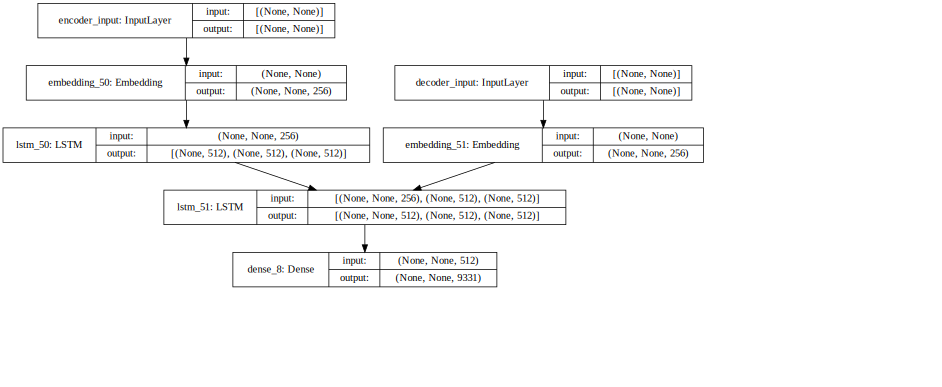

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True, dpi=96).create(prog='dot', format='svg'))

## Train

In [ ]:
import keras
from keras import optimizers
import tensorflow as tf

rmsprop = tf.keras.optimizers.RMSprop(learning_rate=0.0003)

model.compile(optimizer=rmsprop, loss="sparse_categorical_crossentropy")

history=model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                  validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                  batch_size=128,
                  epochs=20)
# 기준 learning_rate = 0.0001, batch_size =128, epochs = 15, loss = 1.4
# batch_size를 줄이니(32) loss가 조금 작아짐.(1.1) train과 val차이가 커짐.
# learning_tate를 증가시켰더니(0,001) loss가 조금 작아짐.(1.1) train과 val차이가 커짐.
# epoch =50 으로 loss 1.1이지만 train과 val의 차가 적음. => 조금씩 여러번 학습하는 게 좋음.
# padding을 post에 한 경우 masking layer가 없으면 학습이 전혀 안됨. (loss=nan)

Epoch 1/20
391/391 [==============================] - 19s 43ms/step - loss: 1.8000 - val_loss: 1.6476
Epoch 2/20
391/391 [==============================] - 17s 43ms/step - loss: 1.3345 - val_loss: 1.5447
Epoch 3/20
391/391 [==============================] - 17s 44ms/step - loss: 1.2514 - val_loss: 1.4797
Epoch 4/20
391/391 [==============================] - 17s 43ms/step - loss: 1.1760 - val_loss: 1.3820
Epoch 5/20
391/391 [==============================] - 17s 43ms/step - loss: 1.1083 - val_loss: 1.3282
Epoch 6/20
391/391 [==============================] - 17s 43ms/step - loss: 1.0605 - val_loss: 1.2803
Epoch 7/20
391/391 [==============================] - 17s 43ms/step - loss: 1.0220 - val_loss: 1.2398
Epoch 8/20
391/391 [==============================] - 17s 43ms/step - loss: 0.9859 - val_loss: 1.2142
Epoch 9/20
391/391 [==============================] - 17s 43ms/step - loss: 0.9525 - val_loss: 1.1677
Epoch 10/20
391/391 [==============================] - 17s 43ms/step - loss: 0.918

In [ ]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'val_loss'])


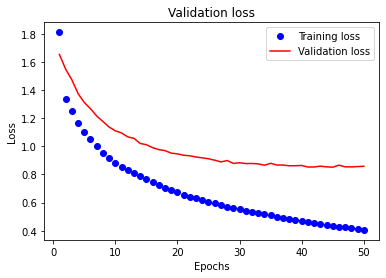

In [ ]:
# padding : post, with masking layer
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model

model.save('translator_model.h5')

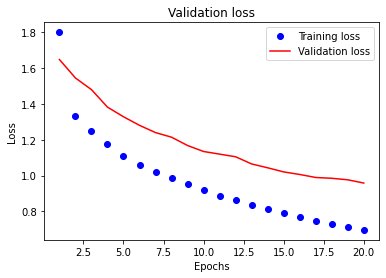

In [ ]:
# padding : post, with masking layer
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import load_model

model.save('translator_model_20.h5')

## bidrectional, attention 적용

In [ ]:
encoder_h.shape

TensorShape([None, 1024])

In [ ]:
import tensorflow as tf
embedding_size = 512
hidden_size = 512
# encoder_states = tf.zeros([encoder_states,encoder_states])

# 인코더 모델
encoder_input = tf.keras.Input(shape=(None,))
encoder_embedding = tf.keras.layers.Embedding(input_dim=eng_vocab_size, output_dim=embedding_size)(encoder_input)

# 양방향 LSTM 레이어
encoder_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_size, dropout = 0.5, return_sequences=True, return_state=True))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)

# 인코더의 상태 정보를 디코더로 전달하기 위한 텐서
encoder_h = tf.keras.layers.Concatenate()([forward_h, backward_h])
encoder_c = tf.keras.layers.Concatenate()([forward_c, backward_c])
# encoder_states = [encoder_h, encoder_c, encoder_h, encoder_c] # = decoder initial_state
encoder_states = [forward_h, forward_c, backward_h, backward_c]

# 디코더 모델
decoder_input = tf.keras.Input(shape=(None,))
decoder_embedding = tf.keras.layers.Embedding(input_dim=fra_vocab_size, output_dim=embedding_size)(decoder_input)

# 양방향 LSTM 레이어
decoder_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=hidden_size, dropout = 0.5, return_sequences=True, return_state=True))  #`return_sequences=True`로 설정하여 모든 시점의 출력을 사용
decoder_outputs = decoder_lstm(decoder_embedding, initial_state = encoder_states ) # len(encoder_states)=2   ????????
# decoder_outputs의 길이가 5개 그 중 알맞은 거 사용하면 됨. 또는 ,_,_,_,_를 사용하면 뒤게 4개 포함하여 따로 저장하지만 뒤 4개는 사용하지 않음.
print(decoder_outputs)
# 어텐션 메커니즘
attn_layer = tf.keras.layers.Attention()([encoder_outputs, decoder_outputs[0]])

# 디코더의 출력층
decoder_concat_input = tf.keras.layers.Concatenate(axis=-1)([decoder_outputs[0], attn_layer])
decoder_dense = tf.keras.layers.Dense(units=fra_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)

# 모델 생성
model_bi = Model([encoder_input, decoder_input], decoder_outputs)
model_bi.summary()

[<KerasTensor: shape=(None, None, 1024) dtype=float32 (created by layer 'bidirectional_47')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'bidirectional_47')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'bidirectional_47')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'bidirectional_47')>, <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'bidirectional_47')>]
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
input_48 (InputLayer)           [(None, None)]       0                                            
__________________________________________________

### Train

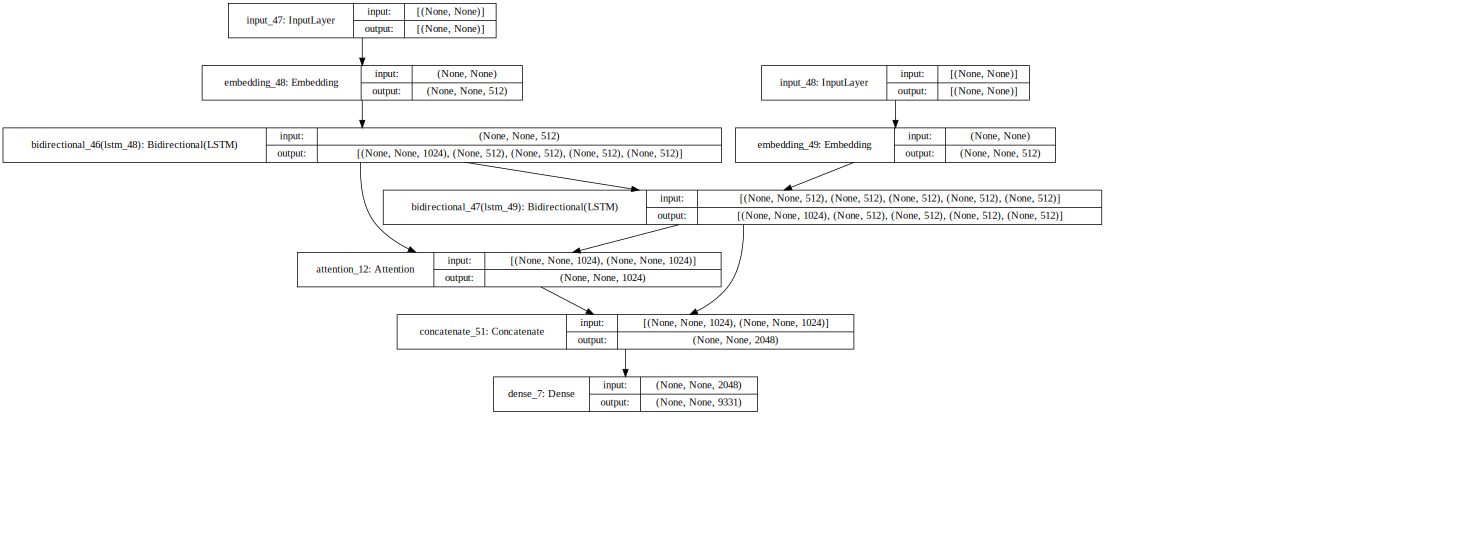

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model_bi, show_shapes=True, dpi=96).create(prog='dot', format='svg'))

# 5 Evaluate

## Get Inference Model

In [ ]:
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, None)]            0         
_________________________________________________________________
embedding_52 (Embedding)     (None, None, 256)         1535488   
_________________________________________________________________
lstm_52 (LSTM)               [(None, 512), (None, 512) 1574912   
Total params: 3,110,400
Trainable params: 3,110,400
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(embedding_size, ))
# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(embedding_size, ))

# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
dec_emb2 =  Embedding(fra_vocab_size, embedding_size)(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state = decoder_states_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장.
decoder_states2 = [state_h2, state_c2]

ValueError: Dimensions must be equal, but are 256 and 512 for '{{node MatMul_1}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](init_h, recurrent_kernel)' with input shapes: [?,256], [512,2048].

In [ ]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs2] + decoder_states2)
decoder_model.summary()

NameError: name 'decoder_outputs2' is not defined

In [ ]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # 에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = fra2idx['<sos>']

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # 에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

## test Model

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def int2ori(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + idx2eng[i]+' ' # 리스트 요소를 묶어 문장으로
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def int2fra(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=fra2idx['<sos>']) and i!=fra2idx['<eos>']): # 토큰 제외하고
            temp = temp + idx2fra[i] + ' '
    return temp

In [ ]:
# padding : post
import numpy as np
for seq_index in [3,50,100,200]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', int2ori(encoder_input_test[seq_index]))
    print('정답 문장:', int2fra(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: they re both smiling . 
정답 문장: elles sourient toutes les deux . 
번역기가 번역한 문장:  te chance faisons faison
-----------------------------------
입력 문장: this answer is wrong . 
정답 문장: cette r ponse est fausse . 
번역기가 번역한 문장:  te chance faisons faison
-----------------------------------
입력 문장: this house is famous . 
정답 문장: cette maison est c l bre . 
번역기가 번역한 문장:  te chance faisons faison
-----------------------------------
입력 문장: this pen has run dry . 
정답 문장: ce stylo n a plus d encre . 
번역기가 번역한 문장:  te chance faisons faison


In [ ]:
# padding : pre
import numpy as np
for seq_index in [3,50,2000,1050]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', int2ori(encoder_input_test[seq_index]))
    print('정답 문장:', int2fra(decoder_input_test[seq_index]))
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: they re both smiling . 
정답 문장: elles sourient toutes les deux . 
번역기가 번역한 문장:  te chance faisons faison
-----------------------------------
입력 문장: this answer is wrong . 
정답 문장: cette r ponse est fausse . 
번역기가 번역한 문장:  te chance faisons faison
-----------------------------------
입력 문장: you misunderstood me . 
정답 문장: tu m as mal compris . 
번역기가 번역한 문장:  te chance faisons chanc
-----------------------------------
입력 문장: we went to the river . 
정답 문장: nous nous rend mes la rivi re . 
번역기가 번역한 문장:  te chance faisons faison


# Review
- 패딩을 pre로 할 경우 모델에서 masking layer가 필요없었지만, post로 할 경우 masking layer가 필요했음
    패딩이 pre일 때 masking layer 없으면 에러.
    masking layer의 역할 : 입력 시퀀스의 일부를 랜덤하게 마스크하여 모델이 해당 부분을 예측하도록 유도 빈칸을 채우거나 문장 생성과 같은 작업을 수행. 문맥을 파악하고 다응ㅁ에 나올 단어나 토큰을 예측할 수 있음.(https://huyntohoon.tistory.com/14)
- 문장 330000를 가지고 여러 시도를 해보았지만(토큰화 방법, dropout 비율, 학습율, 패팅 방법, 문장의 길이 등을 변경하여 학습한 성능이 val loss 기준으로 1.1~ 1.4이었고 번역한 문장은 영어 첫 단어가 같은 모든 같은 단어로 시작하는 프랑스 문장으로 번역됨.
- 학습할 문장을 53000개로 늘렸더니 val loss가 0.8로 상당히 성능 향상이라고 기대했지만 번역된 결과는 앞선 학습과 다르지 않음.
-

https://medium.com/analytics-vidhya/encoder-decoder-seq2seq-models-clearly-explained-c34186fbf49b
https://towardsdatascience.com/how-to-implement-seq2seq-lstm-model-in-keras-shortcutnlp-6f355f3e5639